In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os,sys,glob
from pygeotools.lib import geolib,iolib

In [2]:
from shapely.geometry import Point,Polygon

In [3]:
%cd /nobackupp11/sbhusha1/hma/chamoli/jumbo_skysat/Uttarakhand/Level1B

/nobackupp11/sbhusha1/hma/chamoli/jumbo_skysat/Uttarakhand/Level1B


In [4]:
def point_convert(row):
    #f#rom shapely.geometry import Point
    geom = Point(row['lon'],row['lat'])
    return geom

def df2gdf(df,proj="EPSG:32644"):
    #import geopandas as gpd
    df = df.rename(columns={'# lon':'lon',' lat':'lat',' height_above_datum':'height_above_datum',' mean_residual':'mean_residual'})
    df['geometry'] = df.apply(point_convert, axis=1)
    gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat),crs="EPSG:4326")
    gdf = gdf.to_crs(proj)
    gdf = gdf.sort_values('mean_residual',ascending=True)
    return gdf

In [10]:
reproj_csv_fn = 'cross_track_proc/ba_dense_points/gcp_material/run-initial_residuals_no_loss_function_pointmap_point_log.csv'
reproj_df = pd.read_csv(reproj_csv_fn,skiprows=[1])
reproj_gdf = df2gdf(reproj_df)

In [11]:
reproj_gdf.head(5)

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
2753246,79.723676,30.399050,3837.564258,0.000002,2,POINT (377392.011 3363695.740)
470198,79.745615,30.469605,2904.558693,0.000005,2,POINT (379586.414 3371491.669)
1959870,79.770613,30.432828,3783.949998,0.000006,2,POINT (381941.960 3367389.423)
2697997,79.690767,30.496014,2484.247254,0.000007,2,POINT (374354.821 3374478.420)
1506735,79.735931,30.479157,3718.387682,0.000013,2,POINT (378668.627 3372560.751)


In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


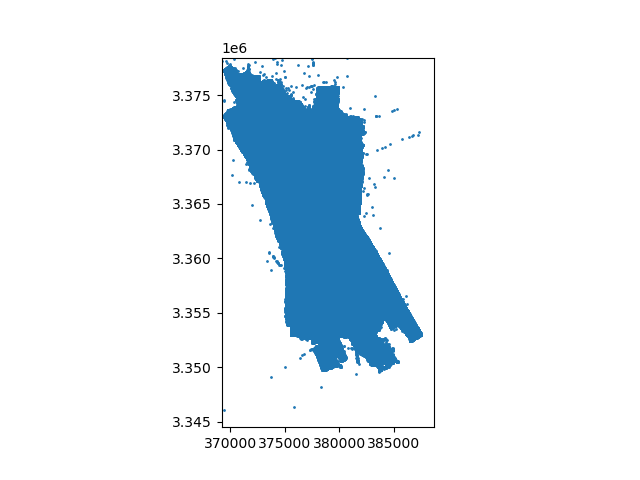

<AxesSubplot:>

In [14]:
f,ax = plt.subplots()
reproj_gdf.plot(ax=ax,markersize=1)

In [15]:
reproj_gdf.sort_values(by=' num_observations',ascending=False).head(400)

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
139439,79.746634,30.400348,4441.608111,17.228861,15,POINT (379599.217 3363814.987)
236524,79.745635,30.366193,5061.065405,41.966061,15,POINT (379461.313 3360030.737)
722559,79.743753,30.372140,5416.222231,7.941938,14,POINT (379287.723 3360691.812)
236467,79.745699,30.366821,4910.198246,32.196439,14,POINT (379468.223 3360100.258)
750867,79.723705,30.362035,5350.767884,18.827984,14,POINT (377348.542 3359593.389)
...,...,...,...,...,...,...
793136,79.728713,30.352992,5432.912875,44.238658,12,POINT (377818.623 3358585.862)
870200,79.705819,30.454124,3221.375035,2.672227,12,POINT (375746.247 3369819.084)
144096,79.747854,30.397302,4218.704336,13.819319,12,POINT (379712.636 3363476.111)
757928,79.722899,30.363919,5295.849463,29.789077,12,POINT (377273.410 3359803.077)


In [16]:
def point_sampler(ds,geom,val='mean',buffer=30,return_gdf=True):
    """
    ad-hoc function for sampling point, until I switch to Friedrich's method
    """
    import rasterstats as rs
    from affine import Affine
    ndv = iolib.get_ndv_ds(ds)
    array = iolib.ds_getma(ds)
    #ds.read(1)
    gt = ds.GetGeoTransform()
    gt = Affine.from_gdal(*gt)
    stat = val
    
    #geom = geom.to_crs(ds.crs)
    x_min,y_min,x_max,y_max = geolib.ds_extent(ds)
    geom = geom.cx[x_min:x_max, y_min:y_max]
    geom['geometry'] = geom.geometry.buffer(buffer)
    json_stats = rs.zonal_stats(geom,array,affine=gt,geojson_out=True,stats=stat,nodata=ndv)
    gdf = gpd.GeoDataFrame.from_features(json_stats)
    if val =='median':
        gdf = gdf.rename(columns={'median':'med'})
        call = 'med'
    else:
        gdf = gdf.rename(columns={'mean':'mean'})
        call = 'mean'
    if ret_gdf:
        out_file = gdf
    else:
        out_file = [gdf.x_atc.values,gdf[call].values]
    return out_file

Use the fine-quality, zenodo pre-event release, filtered for -5 to 5 wrt larger 8m zenodo release

In [17]:
sample_dem = '/nobackup/deshean/hma/chamoli/dg/crosstrack_2015/release/Chamoli_Sept2015_Composite_DEM2m_wmean_dzfilt_-5_5.tif'
dem_ds = iolib.fn_getds(sample_dem)

In [18]:
def mapToPixel(mX, mY, geoTransform):
    """Convert map coordinates to pixel coordinates based on geotransform
    
    Accepts float or NumPy arrays
    GDAL model used here - upper left corner of upper left pixel for mX, mY (and in GeoTransform)
    """
    mX = np.asarray(mX)
    mY = np.asarray(mY)
    if geoTransform[2] + geoTransform[4] == 0:
        pX = ((mX - geoTransform[0]) / geoTransform[1]) - 0.5
        pY = ((mY - geoTransform[3]) / geoTransform[5]) - 0.5
    else:
        pX, pY = applyGeoTransform(mX, mY, invertGeoTransform(geoTransform))
    #return int(pX), int(pY)
    return pX, pY

def sample_ndimage(dem_ma,dem_gt,map_x,map_y,r='bilinear'):
    """
    sample values from the dem masked array for the points in map_x, map_y coordinates
    dem_ma: Masked numpy array, prefer the dem to be conitnous though
    gt: geotransform of dem/input array
    map_x: x_coordinate array
    map_y: y_coordinate array
    r: resampling algorithm for decimal px location
    out: array containing sampled values at zip(map_y,map_x)
    """
    import scipy.ndimage
    #convert map points to px points using geotransform information
    img_x,img_y = mapToPixel(map_x,map_y,dem_gt)
    #prepare input for sampling function
    yx = np.array([img_y,img_x])
    # sample the array
    sampled_pts = scipy.ndimage.map_coordinates(dem_ma, yx, order=1,mode='nearest')
    return sampled_pts


In [19]:
map_x = reproj_gdf.geometry.x.values
map_y = reproj_gdf.geometry.y.values

In [20]:
reproj_gdf['dem_height'] = sample_ndimage(iolib.ds_getma(dem_ds),dem_ds.GetGeoTransform(),map_x,map_y)

In [21]:
reproj_gdf['dh'] = np.abs(reproj_gdf['dem_height'] - reproj_gdf['height_above_datum'])

In [22]:
mask_abs_dh = reproj_gdf['dh'] < 0.75
reproj_gdf_dem_filt = reproj_gdf[mask_abs_dh]

In [23]:
reproj_gdf_dem_filt.describe()

,lon,lat,height_above_datum,mean_residual,num_observations,dem_height,dh
count,62635.000000,62635.000000,62635.000000,62635.000000,62635.000000,62635.000000,62635.000000
mean,79.729430,30.401993,4212.134833,3.774586,4.696001,4212.129395,0.375280
std,0.032917,0.057260,1029.391789,6.116330,2.112396,1029.404053,0.216346
min,79.639818,30.292847,1810.872945,0.000027,2.000000,1810.385254,0.000015
25%,79.707994,30.357583,3457.454712,1.631840,3.000000,3457.417603,0.188221
50%,79.734064,30.391150,4377.947475,2.656497,4.000000,4377.930664,0.375775
75%,79.756529,30.453043,4865.468237,4.250116,6.000000,4865.544678,0.562821
max,79.805593,30.522324,7087.402266,405.887419,13.000000,7088.094238,0.749993


<IPython.core.display.Javascript object>


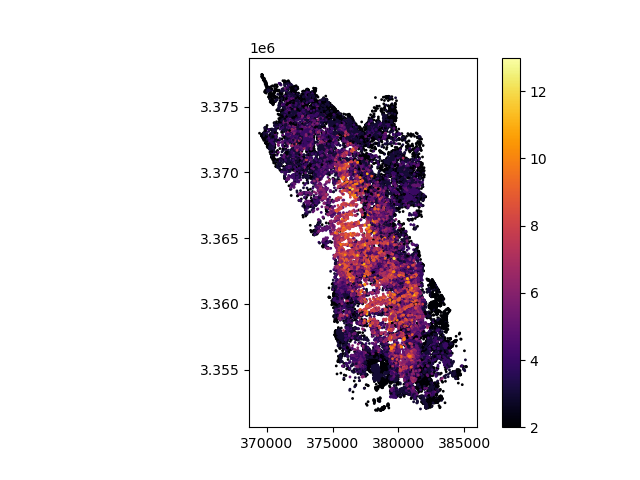

In [24]:
f,ax = plt.subplots()
im = reproj_gdf_dem_filt.plot(ax=ax,markersize=1,column=' num_observations',cmap='inferno',legend='True')


In [25]:
reproj_gdf_dem_filt.sort_values(by=' num_observations',ascending=False)

,lon,lat,height_above_datum,mean_residual,num_observations,geometry,dem_height,dh
842552,79.710122,30.461262,2648.482561,19.947844,13,POINT (376168.520 3370605.434),2648.298340,0.184221
1024043,79.705264,30.399839,4231.570694,4.200507,13,POINT (375624.166 3363803.343),4231.526367,0.044326
842695,79.708662,30.461122,2702.838912,9.839962,12,POINT (376028.117 3370591.503),2702.812012,0.026900
273683,79.745904,30.358870,5156.079614,20.638777,12,POINT (379478.123 3359218.864),5156.126465,0.046851
144147,79.747583,30.397051,4195.926320,13.058536,12,POINT (379686.297 3363448.623),4195.706055,0.220265
...,...,...,...,...,...,...,...,...
1491865,79.747541,30.498134,3645.041315,1.532070,2,POINT (379806.426 3374651.481),3644.708252,0.333063
2918065,79.710768,30.494170,2335.326618,1.531824,2,POINT (376272.100 3374251.922),2335.802246,0.475629
80004,79.768323,30.427377,4139.349203,1.531678,2,POINT (381715.451 3366787.631),4139.054199,0.295004
2729936,79.660797,30.494860,2476.072474,1.531599,2,POINT (371476.937 3374384.185),2475.729004,0.343470


In [26]:
reproj_gdf_dem_filt.sort_values(by=' num_observations',ascending=False).head(30000)

,lon,lat,height_above_datum,mean_residual,num_observations,geometry,dem_height,dh
842552,79.710122,30.461262,2648.482561,19.947844,13,POINT (376168.520 3370605.434),2648.298340,0.184221
1024043,79.705264,30.399839,4231.570694,4.200507,13,POINT (375624.166 3363803.343),4231.526367,0.044326
842695,79.708662,30.461122,2702.838912,9.839962,12,POINT (376028.117 3370591.503),2702.812012,0.026900
273683,79.745904,30.358870,5156.079614,20.638777,12,POINT (379478.123 3359218.864),5156.126465,0.046851
144147,79.747583,30.397051,4195.926320,13.058536,12,POINT (379686.297 3363448.623),4195.706055,0.220265
...,...,...,...,...,...,...,...,...
135161,79.761937,30.397947,5213.601413,5.976346,5,POINT (381066.452 3363532.742),5214.018066,0.416654
540022,79.731544,30.426682,3950.302118,3.484903,5,POINT (378182.188 3366749.720),3950.288574,0.013543
1780465,79.718011,30.456138,3055.764304,3.488866,5,POINT (376919.490 3370028.961),3055.402344,0.361961
1758048,79.716426,30.469046,2221.790487,1.739049,5,POINT (376783.565 3371461.225),2222.361816,0.571329


In [27]:
mask_5_view = reproj_gdf_dem_filt[' num_observations'] >= 5

five_view_idx = reproj_gdf_dem_filt[mask_5_view].index.values

mask_4_view = reproj_gdf_dem_filt[' num_observations'] == 4
four_view_idx = reproj_gdf_dem_filt[mask_4_view].index.values

mask_3_view = reproj_gdf_dem_filt[' num_observations'] == 3
three_view_idx = reproj_gdf_dem_filt[mask_3_view].index.values

mask_2_view = reproj_gdf_dem_filt[' num_observations'] == 2
two_view_idx = reproj_gdf_dem_filt[mask_2_view].index.values

In [28]:
cnet_fn = 'cross_track_proc/ba_dense_points/gcp_material/run-cnet.csv'

In [29]:
with open(cnet_fn,'r') as f:
        content = f.readlines()
content = [x.strip() for x in content]

In [30]:
from tqdm import tqdm

In [31]:
filtered_idx = reproj_gdf_dem_filt.index.values

In [32]:
len(filtered_idx)

62635

In [33]:
final_gcp_list = []
outfn = os.path.splitext(cnet_fn)[0]+'_gcp.gcp'
counter = 1

view_count = []
with open (outfn,'w') as f:
    for idx,line in enumerate(tqdm(content)):
        if idx not in filtered_idx:
            continue
        else:
            
            num_img = line.count('.tif')
    
            view_count.append(num_img)
        
            new_str = f"{counter} {line.split(' ',1)[1]}"
            if idx in five_view_idx:
                #print(new_str)
                new_str = new_str.split(' 1 1 1 ')[0] + ' 0.5 0.5 0.5 '+new_str.split(' 1 1 1 ')[1]
            
            
            elif idx in four_view_idx:
                new_str = new_str.split(' 1 1 1 ')[0] + ' 1.2 1.2 1.2 '+new_str.split(' 1 1 1 ')[1]
            elif idx in three_view_idx:
                new_str = new_str.split(' 1 1 1 ')[0] + ' 1.8 1.8 1.8 '+new_str.split(' 1 1 1 ')[1]
               
            elif idx in two_view_idx:
                new_str = new_str.split(' 1 1 1 ')[0] + ' 2.2 2.2 2.2 '+new_str.split(' 1 1 1 ')[1]
            
            
            
            final_gcp_list.append(new_str)
            counter = counter + 1
            f.write(new_str+'\n')

100%|██████████| 2923555/2923555 [01:38<00:00, 29771.48it/s]


In [116]:
len(final_gcp_list)

62635

### Compare residual

In [35]:
init_reproj_csv_fn = 'cross_track_proc/ba_dense_points/run-initial_residuals_no_loss_function_pointmap_point_log.csv'
init_reproj_df = pd.read_csv(init_reproj_csv_fn,skiprows=[1])
init_reproj_gdf = df2gdf(init_reproj_df)

In [36]:
fn_reproj_csv_fn = 'cross_track_proc/ba_dense_points/run-final_residuals_no_loss_function_pointmap_point_log.csv'
fn_reproj_df = pd.read_csv(fn_reproj_csv_fn,skiprows=[1])
fn_reproj_gdf = df2gdf(fn_reproj_df)

In [38]:
init_reproj_gdf.head()

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
2753246,79.723676,30.399050,3837.564258,0.000002,2,POINT (377392.011 3363695.740)
470198,79.745615,30.469605,2904.558693,0.000005,2,POINT (379586.414 3371491.669)
1959870,79.770613,30.432828,3783.949998,0.000006,2,POINT (381941.960 3367389.423)
2697997,79.690767,30.496014,2484.247254,0.000007,2,POINT (374354.821 3374478.420)
1506735,79.735931,30.479157,3718.387682,0.000013,2,POINT (378668.627 3372560.751)


In [37]:
fn_reproj_gdf.head()

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
2922672,79.667712,30.478641,2576.813593,1.577234e-07,2,POINT (372119.334 3372578.763)
90111,79.754900,30.430490,4806.457753,6.005799e-07,2,POINT (380430.085 3367146.822)
2705043,79.688850,30.481354,2383.447710,1.823530e-06,2,POINT (374152.029 3372855.705)
2872787,79.733865,30.287137,3903.566822,2.007691e-06,2,POINT (378232.391 3351281.779)
2837016,79.740246,30.316023,4251.205094,2.843779e-06,2,POINT (378881.594 3354476.288)


In [39]:
init_reproj_gdf.tail()

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
1763516,79.303010,30.779065,-106385.724917,36260.161755,4,POINT (337611.376 3406348.090)
1482905,79.304474,30.026574,-86126.561554,36727.536591,5,POINT (336502.047 3322940.724)
1482801,79.186567,29.952527,-109785.065070,44869.572529,5,POINT (325000.628 3314908.010)
11889,80.369353,29.054162,-293256.294763,45876.579986,5,POINT (438606.450 3214150.459)
1482800,79.161754,29.936684,-114752.266342,46511.431288,5,POINT (322577.615 3313190.094)


In [40]:
fn_reproj_gdf.tail()

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
2155950,79.768448,30.446511,-7510.595844,2313.297449,3,POINT (381750.557 3368908.132)
2242947,79.825485,30.347345,-5494.354889,2316.835439,3,POINT (387113.419 3357859.600)
421326,79.759564,30.483401,-27371.164427,3332.858537,3,POINT (380942.347 3373005.961)
2088678,79.734354,30.536802,-21042.075128,4039.327988,3,POINT (378588.925 3378951.163)
2921456,79.616617,30.661184,44058.867794,10674.845611,3,POINT (367463.025 3392869.599)


<IPython.core.display.Javascript object>


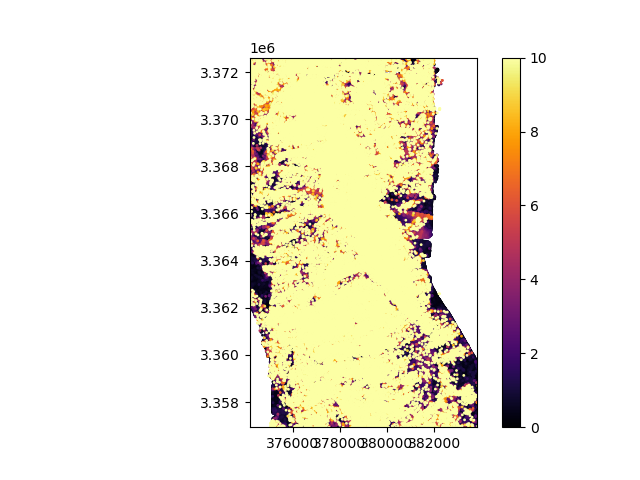

<AxesSubplot:>

In [65]:
f,ax = plt.subplots()
fn_reproj_gdf.plot(column='mean_residual',ax=ax,cmap='inferno',vmin=0,vmax=10,legend=True,markersize=1)


In [48]:
init_reproj_gdf.iloc[421330]

lon                                                     79.716283
lat                                                     30.414998
height_above_datum                                    3640.330653
mean_residual                                            1.101762
 num_observations                                               7
geometry              POINT (376701.7801275385 3365471.312360623)
Name: 984852, dtype: object

In [67]:
init_reproj_gdf[init_reproj_gdf[' num_observations'] == 7].describe()

,lon,lat,height_above_datum,mean_residual
count,293710.000000,293710.000000,293710.000000,293710.000000
mean,79.731928,30.391019,4352.871830,15.570651
std,0.020749,0.038851,807.583061,68.315218
min,79.649194,30.297817,-20186.709073,0.541917
25%,79.714766,30.361300,3749.615754,2.348687
50%,79.730832,30.390064,4420.774247,4.536255
75%,79.750475,30.418644,5024.123295,12.673993
max,79.820195,30.535999,22269.805022,8464.646704


In [69]:
fn_reproj_gdf[fn_reproj_gdf[' num_observations'] == 7].describe()

,lon,lat,height_above_datum,mean_residual
count,293710.000000,293710.000000,293710.000000,293710.000000
mean,79.731937,30.391023,4352.624322,1.711071
std,0.020739,0.038840,800.083358,10.635506
min,79.655609,30.303773,1828.380222,0.040854
25%,79.714768,30.361303,3741.105377,0.263228
50%,79.730840,30.390071,4422.837761,0.375068
75%,79.750470,30.418639,5030.484396,0.605855
max,79.789972,30.506231,7003.603687,606.495242


In [68]:
init_reproj_gdf[init_reproj_gdf[' num_observations'] == 13].describe()

,lon,lat,height_above_datum,mean_residual
count,328.000000,328.000000,328.000000,328.000000
mean,79.727321,30.391444,4496.388977,32.704379
std,0.015862,0.039392,828.676617,49.601114
min,79.702833,30.336424,2501.108880,2.528232
25%,79.709360,30.359664,3661.438075,12.529893
50%,79.724924,30.380309,4914.392502,22.783388
75%,79.745876,30.427417,5139.192035,34.254599
max,79.747888,30.467346,5520.659506,577.733952


In [70]:
fn_reproj_gdf[fn_reproj_gdf[' num_observations'] == 13].describe()

,lon,lat,height_above_datum,mean_residual
count,328.000000,328.000000,328.000000,328.000000
mean,79.727272,30.391451,4492.780388,1.642647
std,0.015770,0.039339,844.383075,7.620902
min,79.702751,30.336630,2509.893829,0.159934
25%,79.709360,30.359398,3638.228731,0.313167
50%,79.724874,30.380812,4836.043502,0.417345
75%,79.745791,30.427386,5136.989936,0.546339
max,79.747788,30.462226,5517.433900,94.896103


In [79]:
init_reproj_gdf[init_reproj_gdf[' num_observations'] == 2].describe()

,lon,lat,height_above_datum,mean_residual
count,553787.000000,553787.000000,553787.000000,553787.000000
mean,79.736475,30.405421,4177.763445,4.784643
std,0.038963,0.069859,1237.501397,20.779616
min,79.638732,30.273107,-3058.365737,0.000002
25%,79.712150,30.336244,3096.415077,0.565989
50%,79.739393,30.420695,4145.821018,1.313164
75%,79.763171,30.467812,5191.789310,2.754214
max,79.830506,30.524456,8050.434971,603.355297


In [74]:
fn_reproj_gdf[fn_reproj_gdf[' num_observations'] == 2].describe()

,lon,lat,height_above_datum,mean_residual
count,553787.000000,553787.000000,553787.000000,5.537870e+05
mean,79.736467,30.405420,4175.738911,3.249132e+00
std,0.038959,0.069873,1238.547346,2.037210e+01
min,79.638841,30.273090,-3193.897851,6.005799e-07
25%,79.712155,30.336238,3090.460806,9.036042e-02
50%,79.739397,30.420699,4142.120521,2.092371e-01
75%,79.763142,30.467824,5196.499354,4.887160e-01
max,79.830391,30.524653,7916.535719,6.033618e+02


In [ ]:
f

In [75]:
fn_reproj_gdf[fn_reproj_gdf[' num_observations'] == 3].describe()

,lon,lat,height_above_datum,mean_residual
count,520522.000000,520522.000000,520522.000000,520522.000000
mean,79.727435,30.411144,4125.278340,4.557166
std,0.035529,0.062860,1169.091176,26.228256
min,79.641072,30.273272,-27371.164427,0.002229
25%,79.703684,30.349917,3130.554499,0.217737
50%,79.730350,30.426661,4192.603018,0.403357
75%,79.752462,30.464032,5020.417731,1.072105
max,79.826672,30.536802,10604.380876,4039.327988


In [76]:
fn_reproj_gdf[fn_reproj_gdf[' num_observations'] == 4].describe()

,lon,lat,height_above_datum,mean_residual
count,475980.000000,475980.000000,475980.000000,475980.000000
mean,79.723328,30.409814,4192.703575,3.422812
std,0.032065,0.055140,1101.806958,16.079722
min,79.641864,30.278883,1746.120817,0.016711
25%,79.699299,30.359905,3298.253549,0.248927
50%,79.724687,30.420167,4327.271992,0.425152
75%,79.747832,30.454990,5006.247692,0.960147
max,79.813905,30.516853,9122.551222,904.650595


In [77]:
fn_reproj_gdf[fn_reproj_gdf[' num_observations'] == 5].describe()

,lon,lat,height_above_datum,mean_residual
count,389001.000000,389001.000000,389001.000000,389001.000000
mean,79.723110,30.403522,4239.137813,2.680489
std,0.027455,0.051261,1037.363315,13.003026
min,79.646299,30.279979,-2971.921524,0.022745
25%,79.705336,30.358838,3443.923584,0.263511
50%,79.723045,30.403849,4415.897279,0.422217
75%,79.744752,30.446763,5072.479126,0.852153
max,79.804369,30.516411,7102.034994,918.597727


In [81]:
len(fn_reproj_gdf)

2986190

In [83]:
fn_reproj_gdf.iloc[2986189]

lon                                                     79.616617
lat                                                     30.661184
height_above_datum                                   44058.867794
mean_residual                                        10674.845611
 num_observations                                               3
geometry              POINT (367463.0246196935 3392869.599013519)
Name: 2921456, dtype: object

In [85]:
fn_reproj_gdf.tail()

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
2155950,79.768448,30.446511,-7510.595844,2313.297449,3,POINT (381750.557 3368908.132)
2242947,79.825485,30.347345,-5494.354889,2316.835439,3,POINT (387113.419 3357859.600)
421326,79.759564,30.483401,-27371.164427,3332.858537,3,POINT (380942.347 3373005.961)
2088678,79.734354,30.536802,-21042.075128,4039.327988,3,POINT (378588.925 3378951.163)
2921456,79.616617,30.661184,44058.867794,10674.845611,3,POINT (367463.025 3392869.599)


In [80]:
fn_reproj_gdf.iloc[-1]

lon                                                     79.616617
lat                                                     30.661184
height_above_datum                                   44058.867794
mean_residual                                        10674.845611
 num_observations                                               3
geometry              POINT (367463.0246196935 3392869.599013519)
Name: 2921456, dtype: object

In [91]:
fn_reproj_gdf[' num_observations'].values.astype('str')

array([' 2', '2', '2', ..., '3', '3', ' 3'], dtype='<U9')

In [44]:
fn_reproj_gdf.sort_values(by='mean_residual',ascending=False).head(10000)

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
2921456,79.616617,30.661184,44058.867794,10674.845611,3,POINT (367463.025 3392869.599)
2088678,79.734354,30.536802,-21042.075128,4039.327988,3,POINT (378588.925 3378951.163)
421326,79.759564,30.483401,-27371.164427,3332.858537,3,POINT (380942.347 3373005.961)
2242947,79.825485,30.347345,-5494.354889,2316.835439,3,POINT (387113.419 3357859.600)
2155950,79.768448,30.446511,-7510.595844,2313.297449,3,POINT (381750.557 3368908.132)
...,...,...,...,...,...,...
2158183,79.744849,30.401439,4397.621245,148.792246,4,POINT (379429.080 3363937.837)
1030257,79.719154,30.401764,3886.991496,148.786990,6,POINT (376960.931 3364001.463)
2436218,79.755742,30.343855,5290.473718,148.772919,5,POINT (380405.472 3357544.396)
2249395,79.807224,30.318926,5686.430407,148.770734,3,POINT (385325.061 3354728.424)


In [56]:
fn_reproj_gdf.iloc[90111]

lon                                                     79.760533
lat                                                     30.328602
height_above_datum                                    5123.340148
mean_residual                                            0.051285
 num_observations                                               2
geometry              POINT (380847.5282360219 3355848.921518762)
Name: 2810524, dtype: object

In [59]:
fn_reproj_gdf.iloc[2837016]

lon                                                     79.741602
lat                                                     30.429259
height_above_datum                                    4499.850735
mean_residual                                            7.694478
 num_observations                                               3
geometry              POINT (379151.3680963848 3367024.519561167)
Name: 1566932, dtype: object

In [58]:
fn_reproj_gdf.describe()

,lon,lat,height_above_datum,mean_residual
count,2.986190e+06,2.986190e+06,2.986190e+06,2.986190e+06
mean,7.972838e+01,3.040304e+01,4.229962e+03,3.038933e+00
std,3.128127e-02,5.552494e-02,1.056610e+03,1.901419e+01
min,7.961662e+01,3.027309e+01,-2.737116e+04,1.577234e-07
25%,7.970873e+01,3.035716e+01,3.405809e+03,2.236410e-01
50%,7.972907e+01,3.040339e+01,4.334821e+03,3.727774e-01
75%,7.975033e+01,3.045030e+01,5.046257e+03,7.597286e-01
max,7.983039e+01,3.066118e+01,4.405887e+04,1.067485e+04


In [92]:
num_obs_str = fn_reproj_gdf[' num_observations'].values
num_obs_str

array([' 2', 2, 2, ..., 3, 3, ' 3'], dtype=object)

In [100]:
type(num_obs_str[1])

int

In [117]:
init_mask = fn_reproj_gdf[' num_observations'].str.contains(' # GCP')

In [118]:
init_mask

2922672    False
90111        NaN
2705043      NaN
2872787      NaN
2837016      NaN
           ...  
2155950      NaN
2242947      NaN
421326       NaN
2088678      NaN
2921456    False
Name:  num_observations, Length: 2986190, dtype: object

In [119]:
init_mask.fillna(False,inplace=True)

In [120]:
fn_reproj_gdf_gcp_residual = fn_reproj_gdf[init_mask]

In [121]:
fn_reproj_gdf_gcp_residual.describe()

,lon,lat,height_above_datum,mean_residual
count,62635.000000,62635.000000,62635.000000,62635.000000
mean,79.729430,30.401993,4212.111654,2.896390
std,0.032916,0.057260,1029.408102,6.023836
min,79.639816,30.292845,1810.474005,0.021985
25%,79.707997,30.357579,3457.066646,0.752356
50%,79.734062,30.391151,4377.868748,1.649843
75%,79.756529,30.453042,4865.568180,3.389996
max,79.805593,30.522325,7087.367130,405.157288


In [122]:
fn_reproj_gdf_gcp_residual.describe()

,lon,lat,height_above_datum,mean_residual
count,62635.000000,62635.000000,62635.000000,62635.000000
mean,79.729430,30.401993,4212.111654,2.896390
std,0.032916,0.057260,1029.408102,6.023836
min,79.639816,30.292845,1810.474005,0.021985
25%,79.707997,30.357579,3457.066646,0.752356
50%,79.734062,30.391151,4377.868748,1.649843
75%,79.756529,30.453042,4865.568180,3.389996
max,79.805593,30.522325,7087.367130,405.157288


In [124]:
(len(fn_reproj_gdf_gcp_residual)/len(fn_reproj_gdf))*100

2.097488773319849

In [126]:
def filter_gcp_residual(gdf):
    init_mask = gdf[' num_observations'].str.contains(' # GCP')
    init_mask.fillna(False,inplace=True)
    gcp_residual = gdf[init_mask]
    tiepoint_residual = gdf[~init_mask]
    return gcp_residual,tiepoint_residual

In [128]:
init_reproj_gdf_gcp_residual,init_reproj_tiepoint_residual = filter_gcp_residual(init_reproj_gdf)

In [130]:
init_reproj_gdf_gcp_residual.describe()

,lon,lat,height_above_datum,mean_residual
count,62635.000000,62635.000000,62635.000000,62635.000000
mean,79.729430,30.401993,4212.134833,3.774586
std,0.032917,0.057260,1029.391789,6.116330
min,79.639818,30.292847,1810.872945,0.000027
25%,79.707994,30.357583,3457.454712,1.631840
50%,79.734064,30.391150,4377.947475,2.656497
75%,79.756529,30.453043,4865.468237,4.250116
max,79.805593,30.522324,7087.402266,405.887419


In [131]:
fn_reproj_gdf_gcp_residual,fn_reproj_tiepoint_residual = filter_gcp_residual(fn_reproj_gdf)

In [132]:
fn_reproj_gdf_gcp_residual.describe()

,lon,lat,height_above_datum,mean_residual
count,62635.000000,62635.000000,62635.000000,62635.000000
mean,79.729430,30.401993,4212.111654,2.896390
std,0.032916,0.057260,1029.408102,6.023836
min,79.639816,30.292845,1810.474005,0.021985
25%,79.707997,30.357579,3457.066646,0.752356
50%,79.734062,30.391151,4377.868748,1.649843
75%,79.756529,30.453042,4865.568180,3.389996
max,79.805593,30.522325,7087.367130,405.157288


In [135]:
init_reproj_tiepoint_residual.describe()

,lon,lat,height_above_datum,mean_residual
count,2.923555e+06,2.923555e+06,2.923555e+06,2.923555e+06
mean,7.972835e+01,3.040306e+01,4.231219e+03,1.333590e+01
std,3.127485e-02,5.552691e-02,1.158032e+03,1.068578e+02
min,7.916175e+01,2.790303e+01,-5.108145e+05,2.477131e-06
25%,7.970873e+01,3.035716e+01,3.414103e+03,1.685913e+00
50%,7.972893e+01,3.040377e+01,4.333042e+03,3.271107e+00
75%,7.975019e+01,3.045024e+01,5.042824e+03,7.982410e+00
max,8.085980e+01,3.080286e+01,7.294778e+04,4.651143e+04


In [140]:
init_reproj_tiepoint_residual.quantile(0.90)

lon                     79.765148
lat                     30.476547
height_above_datum    5499.204620
mean_residual           24.306909
Name: 0.9, dtype: float64

In [141]:
init_reproj_tiepoint_residual.quantile(0.95)

lon                     79.776538
lat                     30.487242
height_above_datum    5823.404654
mean_residual           46.080258
Name: 0.95, dtype: float64

In [139]:
fn_reproj_tiepoint_residual.quantile(0.90)

lon                     79.765128
lat                     30.476541
height_above_datum    5505.867713
mean_residual            2.450054
Name: 0.9, dtype: float64

In [142]:
fn_reproj_tiepoint_residual.quantile(0.95)

lon                     79.776542
lat                     30.487237
height_above_datum    5827.077676
mean_residual            7.633411
Name: 0.95, dtype: float64

In [134]:
fn_reproj_tiepoint_residual.describe()

,lon,lat,height_above_datum,mean_residual
count,2.923555e+06,2.923555e+06,2.923555e+06,2.923555e+06
mean,7.972835e+01,3.040306e+01,4.230345e+03,3.041987e+00
std,3.124493e-02,5.548696e-02,1.057182e+03,1.919655e+01
min,7.961662e+01,3.027309e+01,-2.737116e+04,1.577234e-07
25%,7.970875e+01,3.035715e+01,3.405017e+03,2.212614e-01
50%,7.972896e+01,3.040378e+01,4.333446e+03,3.661742e-01
75%,7.975019e+01,3.045027e+01,5.050187e+03,7.249739e-01
max,7.983039e+01,3.066118e+01,4.405887e+04,1.067485e+04


In [153]:
init_reproj_gdf[init_reproj_gdf[' num_observations'] == ' 10 # GCP'].describe()

,lon,lat,height_above_datum,mean_residual
count,464.000000,464.000000,464.000000,464.000000
mean,79.722767,30.406693,4074.828193,8.854259
std,0.017345,0.033930,651.122018,11.553121
min,79.700862,30.330105,2259.547201,1.081282
25%,79.709638,30.385366,3600.946838,4.148412
50%,79.714678,30.400261,4156.674426,5.558672
75%,79.733487,30.443337,4489.689812,9.051474
max,79.766096,30.471409,5701.922609,118.393631


In [154]:
fn_reproj_gdf[fn_reproj_gdf[' num_observations'] == ' 2 # GCP'].describe()

,lon,lat,height_above_datum,mean_residual
count,12034.000000,12034.000000,12034.000000,12034.000000
mean,79.729960,30.407733,4202.181510,2.422786
std,0.040046,0.071558,1294.249308,6.670311
min,79.639816,30.292845,1810.474005,0.021985
25%,79.700094,30.335640,3090.687317,0.477215
50%,79.736875,30.408615,4229.554647,1.348896
75%,79.764295,30.478012,5233.697029,2.841816
max,79.805593,30.522325,7087.367130,405.157288


In [146]:
init_reproj_gdf[init_reproj_gdf[' num_observations'] == ' 12 # GCP']

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
2945604,79.711736,30.446469,3603.355080,4.554223,12 # GCP,POINT (376304.782 3368964.126)
2945990,79.711912,30.446048,3617.552869,4.747896,12 # GCP,POINT (376321.162 3368917.289)
2947165,79.706414,30.400022,4162.812919,4.802047,12 # GCP,POINT (375734.885 3363822.289)
2946062,79.711960,30.446128,3614.989021,4.887742,12 # GCP,POINT (376325.876 3368926.074)
2946011,79.710338,30.445550,3635.553028,5.213666,12 # GCP,POINT (376169.305 3368863.802)
2945451,79.708726,30.448846,3475.105538,5.284549,12 # GCP,POINT (376018.725 3369230.928)
2945984,79.713823,30.442871,3648.010434,5.503607,12 # GCP,POINT (376500.635 3368563.087)
2925255,79.747293,30.397087,4187.211952,9.323857,12 # GCP,POINT (379658.501 3363452.895)
2945977,79.714228,30.443901,3737.865560,9.455834,12 # GCP,POINT (376540.801 3368676.788)
2945238,79.708662,30.461122,2702.838912,9.839962,12 # GCP,POINT (376028.117 3370591.503)


In [147]:
fn_reproj_gdf[fn_reproj_gdf[' num_observations'] == ' 12 # GCP']

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
2945604,79.711734,30.446468,3603.415152,2.445967,12 # GCP,POINT (376304.583 3368964.107)
2946011,79.710335,30.445549,3635.583470,2.991985,12 # GCP,POINT (376169.094 3368863.764)
2946062,79.711959,30.446127,3615.025998,3.059516,12 # GCP,POINT (376325.692 3368926.069)
2945990,79.711910,30.446048,3617.586378,3.077935,12 # GCP,POINT (376320.971 3368917.293)
2947165,79.706416,30.400021,4162.799795,3.913218,12 # GCP,POINT (375735.032 3363822.197)
2945984,79.713824,30.442870,3648.019433,4.585725,12 # GCP,POINT (376500.683 3368562.963)
2945451,79.708726,30.448847,3475.087566,5.571386,12 # GCP,POINT (376018.716 3369231.050)
2925255,79.747293,30.397088,4187.202571,7.628631,12 # GCP,POINT (379658.500 3363452.974)
2943952,79.743371,30.372398,5436.755963,7.637147,12 # GCP,POINT (379251.319 3360720.824)
2945238,79.708661,30.461122,2702.841955,9.137863,12 # GCP,POINT (376028.046 3370591.533)


<IPython.core.display.Javascript object>


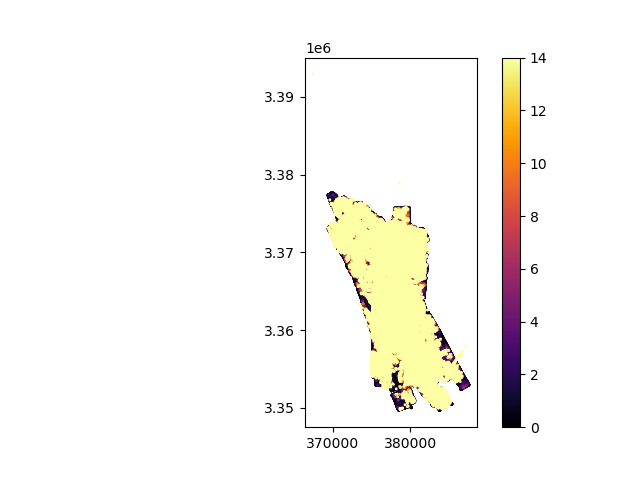

<AxesSubplot:>

In [144]:
f,ax = plt.subplots()
fn_reproj_tiepoint_residual.plot(column='mean_residual',ax=ax,cmap='inferno',vmin=0,vmax=14,legend=True,markersize=1)


##### Camera error observations

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from skysat_stereo import asp_utils as asp

In [6]:
def camera_reprojection_error_stats_df(pixel_error_fn):
    """
    Return dataframe of descriptive stats for pixel reprojection errors corresponding to each camera
    Parameters
    ------------
    pixel_error_fn: str
        path to run-final_residuals_no_loss_function_raw_pixels.txt or similar, written by ASP bundle_adjust
    Returns
    ------------
    stats_df: Dataframe
        descriptive stats for pixel reprojection errors for each camera
    """
    # read the text file, line by line
    with open(pixel_error_fn,'r') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # compute position of camera filename
    camera_indices = []

    for idx,line in enumerate(content):
        # cameras can be of three types, pinhole tsai, rpc embedded in tif or standalone as xml
        if any(substring in line for substring in ['tif','tsai','.xml']):
            camera_indices.append(idx)
    n_cam = len(camera_indices)
    print(f"Total number of cameras are {n_cam}")
    
    # read indices (line numbers) of pixel points for each camera
    pts_indices = []
    for idx,cam_idx in enumerate(camera_indices):
        if idx != len(camera_indices)-1:
            pts_indices.append(np.arange(cam_idx+1,camera_indices[idx+1]))
        else:
            pts_indices.append(np.arange(cam_idx+1,len(content)))
    
    # compute statistics for all pixels in 1 camera, in parallel
    stats_list = p_map(compute_cam_px_reproj_err_stats,[content]*n_cam,pts_indices)
    
    # compose dataframe based on the returned list of dictionaries
    stats_df = pd.DataFrame(stats_list)
    
    # assign input camera name 
    cam_names = np.array(content)[camera_indices]
    temp_cam = np.char.split(np.array(content)[camera_indices],', ')
    stats_df['camera'] = np.array([os.path.basename(x[0]) for x in temp_cam])
    
    # dataframe is good to go
    return stats_df

In [6]:
initial_camera_error = 'cross_track_proc/ba_dense_points/run-initial_residuals_no_loss_function_raw_pixels.txt'

In [7]:
! ls -lha $initial_camera_error

-rw------- 1 sbhusha1 s3224 554M Mar 18 18:07 cross_track_proc/ba_dense_points/run-initial_residuals_no_loss_function_raw_pixels.txt


In [8]:
# read the text file, line by line
with open(initial_camera_error,'r') as f:
    content = f.readlines()
content = [x.strip() for x in content]

In [9]:
# compute position of camera filename
camera_indices = []

for idx,line in enumerate(content):
    # cameras can be of three types, pinhole tsai, rpc embedded in tif or standalone as xml
    if any(substring in line for substring in ['tif','tsai','.xml']):
        camera_indices.append(idx)
n_cam = len(camera_indices)
print(f"Total number of cameras are {n_cam}")

Total number of cameras are 649


In [10]:
# compute position of camera filename
camera_indices = []

for idx,line in enumerate(content):
    # cameras can be of three types, pinhole tsai, rpc embedded in tif or standalone as xml
    if any(substring in line for substring in ['tif','tsai','.xml']):
        camera_indices.append(idx)
n_cam = len(camera_indices)
print(f"Total number of cameras are {n_cam}")
# read indices (line numbers) of pixel points for each camera
pts_indices = []
for idx,cam_idx in enumerate(camera_indices):
    if idx != len(camera_indices)-1:
        pts_indices.append(np.arange(cam_idx+1,camera_indices[idx+1]))
    else:
        pts_indices.append(np.arange(cam_idx+1,len(content)))

In [14]:
pts_indices[0]

array([    1,     2,     3, ..., 12245, 12246, 12247])

In [10]:
asp.compute_cam_px_reproj_err_stats(content,pts_indices[0])

{'count': 12247,
 'min': 0.00016382682399891722,
 'max': 67424.6677620004,
 'ptp': 67424.66759817358,
 'mean': 39.16125344879408,
 'std': 900.6704953272971,
 'nmad': 4.873783848554109,
 'med': 6.052033316025706,
 'median': 6.052033316025706,
 'p16': 2.1823144233718264,
 'p84': 15.171820792137101,
 'spread': 6.494753184382637,
 'mode': 1.1815322790718568}

In [15]:
initial_camera_errorial_camera_error

'cross_track_proc/ba_dense_points/run-initial_residuals_no_loss_function_raw_pixels.txt'

In [16]:
pts_indices[100]

array([2378616, 2378617, 2378618, ..., 2411938, 2411939, 2411940])

In [11]:
asp.compute_cam_px_reproj_err_stats_alt(initial_camera_error,pts_indices[100])

{'count': 33325,
 'min': 0.00011653107165889832,
 'max': 2516.9592618402944,
 'ptp': 2516.9591453092225,
 'mean': 62.14487902254191,
 'std': 153.11717993811598,
 'nmad': 7.642497675924755,
 'med': 6.508685754277842,
 'median': 6.508685754277842,
 'p16': 1.6858711563979918,
 'p84': 63.26122217804809,
 'spread': 30.787675510825046,
 'mode': 0.13258848014883676}

In [21]:
combined_var = list(zip([initial_camera_error]*len(pts_indices),pts_indices))

In [22]:
combined_var[0][1]

array([    1,     2,     3, ..., 12245, 12246, 12247])

In [20]:
def wrapper_stats(combined_var):
    content = combined_var[0]
    pts_indices = combined_var[1]
    return asp.compute_cam_px_reproj_err_stats_alt(content,pts_indices)

In [18]:
wrapper_stats(combined_var[100])

{'count': 33325,
 'min': 0.00011653107165889832,
 'max': 2516.9592618402944,
 'ptp': 2516.9591453092225,
 'mean': 62.14487902254191,
 'std': 153.11717993811598,
 'nmad': 7.642497675924755,
 'med': 6.508685754277842,
 'median': 6.508685754277842,
 'p16': 1.6858711563979918,
 'p84': 63.26122217804809,
 'spread': 30.787675510825046,
 'mode': 0.13258848014883676}

In [27]:
len(combined_var)

1

In [28]:
len(pts_indices)

649

In [32]:
combined_var[1][1]

array([12249, 12250, 12251, ..., 30568, 30569, 30570])

In [43]:
wrapper_stats(combined_var[0])

{'count': 12247,
 'min': 0.00016382682399891722,
 'max': 67424.6677620004,
 'ptp': 67424.66759817358,
 'mean': 39.16125344879408,
 'std': 900.6704953272971,
 'nmad': 4.873783848554109,
 'med': 6.052033316025706,
 'median': 6.052033316025706,
 'p16': 2.1823144233718264,
 'p84': 15.171820792137101,
 'spread': 6.494753184382637,
 'mode': 1.1815322790718568}

In [44]:
wrapper_stats(combined_var[200])

{'count': 21810,
 'min': 0.0010461225321093425,
 'max': 35473.80233424779,
 'ptp': 35473.80128812526,
 'mean': 34.807519299095105,
 'std': 631.1604577971734,
 'nmad': 2.9074848168674037,
 'med': 4.445687017659328,
 'median': 4.445687017659328,
 'p16': 2.4094392100995825,
 'p84': 25.34339560545289,
 'spread': 11.466978197676655,
 'mode': 2.4471132860417746}

In [35]:
wrapper_stats(combined_var[640])

{'count': 18098,
 'min': 4.425263896351287e-05,
 'max': 577.3740078195948,
 'ptp': 577.3739635669558,
 'mean': 4.859050634369351,
 'std': 14.655901121256301,
 'nmad': 1.7106698904597377,
 'med': 2.2669921959245602,
 'median': 2.2669921959245602,
 'p16': 0.9659659385866312,
 'p84': 4.891290075217205,
 'spread': 1.9626620683152867,
 'mode': 4.425263896351287e-05}

In [25]:
from joblib import Parallel, delayed

In [26]:
Parallel(n_jobs=2)(delayed(np.sqrt)(i ** 2) for i in range(10))

In [12]:
from p_tqdm import p_map

In [22]:
len(pts_indices)

649

for i,idx in enumerate(pts_indices):
    print(f"{i}:{len(idx)}")

In [ ]:
content[6]

In [38]:
dicti = {'count': 4,
 'min': 0.0,
 'max': 0.0,
 'ptp': 0.0,
 'mean': 0.0,
 'std': 0.0,
 'nmad': 0.0,
 'med': 0.0,
 'median': 0.0,
 'p16': 0.0,
 'p84': 0.0,
 'spread': 0.0,
 'mode': 0.0}

In [39]:
dicti

{'count': 4,
 'min': 0.0,
 'max': 0.0,
 'ptp': 0.0,
 'mean': 0.0,
 'std': 0.0,
 'nmad': 0.0,
 'med': 0.0,
 'median': 0.0,
 'p16': 0.0,
 'p84': 0.0,
 'spread': 0.0,
 'mode': 0.0}

In [41]:
asp.compute_cam_px_reproj_err_stats_alt(initial_camera_error,pts_indices[464])

{'count': 0,
 'min': 0.0,
 'max': 0.0,
 'ptp': 0.0,
 'mean': 0.0,
 'std': 0.0,
 'nmad': 0.0,
 'med': 0.0,
 'median': 0.0,
 'p16': 0.0,
 'p84': 0.0,
 'spread': 0.0,
 'mode': 0.0}

In [30]:
py = np.array([0,0,0,0])

In [31]:
from pygeotools.lib import malib

In [32]:
malib.get_stats_dict(px)

{'count': 4,
 'min': 0.0,
 'max': 0.0,
 'ptp': 0.0,
 'mean': 0.0,
 'std': 0.0,
 'nmad': 0.0,
 'med': 0.0,
 'median': 0.0,
 'p16': 0.0,
 'p84': 0.0,
 'spread': 0.0,
 'mode': 0.0}

In [13]:
q = p_map(asp.compute_cam_px_reproj_err_stats_alt,[initial_camera_error]*len(pts_indices),pts_indices,num_cpus=15)

  0%|          | 0/649 [00:00<?, ?it/s]

In [15]:
initial_camera_error_df = pd.DataFrame(q)

In [16]:
initial_camera_error_df.describe()

,count,min,max,ptp,mean,std,nmad,med,median,p16,p84,spread,mode
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,21104.177196,0.129624,9967.188718,9967.059094,26.483104,157.231918,5.473559,6.711943,6.711943,2.758560,28.862112,13.051776,3.041151
std,10347.967912,2.509157,18417.575338,18417.635848,24.327456,247.315420,10.064069,11.244043,11.244043,5.181569,36.842126,16.856527,7.725873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13138.000000,0.000801,1599.567403,1599.565567,14.379293,47.784596,2.433481,2.934959,2.934959,1.078056,13.271411,5.470828,0.394919
50%,20804.000000,0.002004,4355.344697,4355.340611,20.250865,86.503826,3.610158,4.390856,4.390856,1.629403,21.830640,9.865156,1.132313
75%,29463.000000,0.006659,10923.848797,10923.847504,29.910520,164.573678,5.623047,6.631508,6.631508,2.835055,32.048972,14.704057,2.684730
max,47928.000000,63.523106,253684.455209,253684.447753,240.673646,2517.357027,160.828170,161.788101,161.788101,67.305462,495.684662,222.540746,113.501851


In [17]:
fn_camera_error = 'cross_track_proc/ba_dense_points/run-final_residuals_no_loss_function_raw_pixels.txt'

In [19]:
# read the text file, line by line
with open(fn_camera_error,'r') as f:
    content = f.readlines()
content = [x.strip() for x in content]

In [20]:
# compute position of camera filename
camera_indices = []

for idx,line in enumerate(content):
    # cameras can be of three types, pinhole tsai, rpc embedded in tif or standalone as xml
    if any(substring in line for substring in ['tif','tsai','.xml']):
        camera_indices.append(idx)
n_cam = len(camera_indices)
print(f"Total number of cameras are {n_cam}")
# read indices (line numbers) of pixel points for each camera
pts_indices = []
for idx,cam_idx in enumerate(camera_indices):
    if idx != len(camera_indices)-1:
        pts_indices.append(np.arange(cam_idx+1,camera_indices[idx+1]))
    else:
        pts_indices.append(np.arange(cam_idx+1,len(content)))

Total number of cameras are 649


In [21]:
q = p_map(asp.compute_cam_px_reproj_err_stats_alt,[fn_camera_error]*len(pts_indices),pts_indices,num_cpus=15)

  0%|          | 0/649 [00:00<?, ?it/s]

In [22]:
fn_camera_error_df = pd.DataFrame(q)

In [23]:
fn_camera_error_df.describe()

,count,min,max,ptp,mean,std,nmad,med,median,p16,p84,spread,mode
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,21104.177196,0.000529,1247.683578,1247.683049,7.067381,39.492916,1.463995,1.232364,1.232364,0.141881,7.334457,3.596288,0.000529
std,10347.967912,0.003176,2445.662927,2445.663006,20.908221,45.254987,13.897428,11.054887,11.054887,0.191399,46.977581,23.474960,0.003176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13138.000000,0.000090,758.102595,758.102242,1.792714,16.690095,0.247878,0.284229,0.284229,0.106524,0.949533,0.413241,0.000090
50%,20804.000000,0.000234,1014.818988,1014.818695,3.035352,27.768227,0.328456,0.361606,0.361606,0.133124,1.388888,0.614904,0.000234
75%,29463.000000,0.000477,1345.401159,1345.400707,5.678036,46.280270,0.453844,0.460667,0.460667,0.157963,2.048092,0.952491,0.000477
max,47928.000000,0.079968,55283.552273,55283.552160,370.690757,502.583788,321.545368,258.919239,258.919239,4.768042,819.024864,409.496268,0.079968


In [30]:
0.97*649

629.53

In [33]:
len(fn_camera_error_df[fn_camera_error_df['nmad']>1])

29

#### 29 cameras had NMAD errors larger greater 1 m.

In [29]:
fn_camera_error_df.quantile(0.97)

count     38892.560000
min           0.001850
max        2898.861851
ptp        2898.861763
mean         33.218910
std         129.654240
nmad          1.272513
med           1.021653
median        1.021653
p16           0.225818
p84          12.279989
spread        6.055605
mode          0.001850
Name: 0.97, dtype: float64

Parallel(n_jo(delayed(wrapper_stats)(i) for i in combined_var[0])

from multiprocessing import get_context

with get_context("spawn").Pool() as pool:
    #schedule one map/worker for each row in the original data
    q = pool.map(wrapper_stats, [var for var in combined_var])

init_camera_errors = asp.camera_reprojection_error_stats_df('cross_track_proc/ba_dense_points/run-initial_residuals_no_loss_function_raw_pixels.txt')

This part is old

#### Now Seth (Planet) told that the he uses GCPs with errors less than 0.3 m errors in bundle adjust. We can backtrack that in pixel reprojection error to use a similar filter.

In [10]:
# if 0.75 m is 1 px
# 1 m is 1/0.75 px
# so 0.3 m is 0.3/0.75 px
expected_mean_reproj_error = np.round(0.3/0.75,2)

In [11]:
expected_mean_reproj_error

0.4

In [12]:
## Apply and check distribution, num observations
reproj_err_mask = reproj_gdf['mean_residual'] <= expected_mean_reproj_error
reproj_gdf_filt = reproj_gdf[reproj_err_mask]

In [13]:
len(reproj_gdf)

1151649

In [14]:
len(reproj_gdf_filt)

381079

In [15]:
ht_flt = (reproj_gdf_filt['height_above_datum'] > 8000) | (reproj_gdf_filt['height_above_datum'] < 1000)

In [16]:
reproj_gdf_filt.describe()

,lon,lat,height_above_datum,mean_residual,num_observations
count,381079.000000,381079.000000,381079.000000,3.810790e+05,381079.000000
mean,79.721015,30.399949,4240.469957,1.910528e-01,2.114853
std,0.030283,0.044762,878.107191,1.140637e-01,0.400854
min,79.641254,30.273600,-10448.492359,7.304696e-07,2.000000
25%,79.700810,30.368951,3723.061563,9.224400e-02,2.000000
50%,79.715968,30.396387,4374.268068,1.868718e-01,2.000000
75%,79.743900,30.431984,4825.985173,2.873373e-01,2.000000
max,79.829297,30.516356,13640.506243,3.999980e-01,10.000000


In [17]:
reproj_gdf_filt[~ht_flt].describe()

,lon,lat,height_above_datum,mean_residual,num_observations
count,380967.000000,380967.000000,380967.000000,3.809670e+05,380967.000000
mean,79.721013,30.399949,4240.393060,1.910513e-01,2.114887
std,0.030283,0.044759,873.679803,1.140636e-01,0.400908
min,79.641254,30.273600,1010.863066,7.304696e-07,2.000000
25%,79.700808,30.368953,3723.275014,9.224159e-02,2.000000
50%,79.715962,30.396388,4374.261287,1.868759e-01,2.000000
75%,79.743899,30.431980,4825.828520,2.873399e-01,2.000000
max,79.829297,30.516356,7999.051356,3.999980e-01,10.000000


In [18]:
reproj_gdf_filt = reproj_gdf_filt[~ht_flt]

In [19]:
reproj_gdf_filt.head(5)

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
59451,79.758927,30.325591,5164.950002,7.304696e-07,2,POINT (8878723.086 3545470.573)
446362,79.768482,30.380703,4800.277145,1.453599e-06,2,POINT (8879786.794 3552580.172)
2808,79.754131,30.461826,3374.043397,2.333794e-06,2,POINT (8878189.259 3563052.519)
384164,79.721211,30.343106,5634.109382,2.530400e-06,2,POINT (8874524.614 3547729.544)
362888,79.724846,30.337184,5224.425069,4.142870e-06,2,POINT (8874929.313 3546965.711)


In [20]:
reproj_gdf_filt.tail(5)

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
807658,79.735969,30.355123,5184.306271,0.399991,2,POINT (8876167.459 3549279.716)
513619,79.669482,30.479954,2486.374695,0.399995,2,POINT (8868766.118 3565393.839)
1040265,79.672088,30.471227,2837.293106,0.399996,2,POINT (8869056.277 3564266.597)
1110481,79.688020,30.394281,4974.550113,0.399996,2,POINT (8870829.827 3554332.277)
50892,79.761846,30.341101,4958.070862,0.399998,2,POINT (8879048.040 3547471.020)


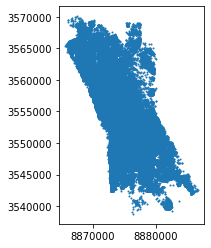

In [21]:
f,ax = plt.subplots()
reproj_gdf_filt.plot(ax=ax,markersize=1)

In [64]:
reproj_gdf_filt.sort_values(by=' num_observations',ascending=False).head(40)

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
637254,79.700939,30.414055,4119.465537,0.250909,10,POINT (8872267.907 3556884.612)
630561,79.699720,30.414771,4158.934711,0.377171,9,POINT (8872132.302 3556976.993)
637224,79.700088,30.414006,4154.121095,0.358798,9,POINT (8872173.233 3556878.238)
442627,79.673228,30.467665,2879.361538,0.385116,8,POINT (8869183.141 3563806.570)
637309,79.698846,30.413454,4229.267203,0.385466,8,POINT (8872034.915 3556806.946)
639551,79.700110,30.414040,4151.959666,0.374632,8,POINT (8872175.681 3556882.583)
634435,79.697824,30.413792,4270.729736,0.378303,8,POINT (8871921.167 3556850.633)
638489,79.698335,30.413441,4255.462096,0.391839,8,POINT (8871978.028 3556805.321)
637490,79.699138,30.414524,4192.673636,0.303376,8,POINT (8872067.476 3556945.040)
637500,79.700173,30.414952,4135.442743,0.208763,8,POINT (8872182.660 3557000.391)


In [22]:
mask_num_obs = reproj_gdf_filt[' num_observations'] > 3
reproj_gdf_filt_num_obs_filt = reproj_gdf_filt[mask_num_obs]

In [23]:
len(reproj_gdf_filt_num_obs_filt)

7072

In [33]:
%matplotlib notebook

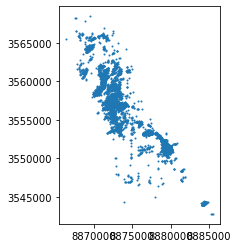

In [24]:
f,ax = plt.subplots()
reproj_gdf_filt_num_obs_filt.plot(ax=ax,markersize=1)

In [25]:
cnet_fn = 'cross_track_proc/ba_pinhole_gcp_full_match/gcp_material/run-cnet.csv'

In [26]:
reproj_gdf.sort_index()

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
0,79.770943,30.441246,-1459.663670,11.283261,2,POINT (8880060.722 3560394.957)
1,79.763363,30.458604,1817.236800,9.573134,2,POINT (8879216.973 3562636.329)
2,79.767622,30.446973,-569.799713,6.868856,2,POINT (8879691.028 3561134.467)
3,79.765665,30.446654,-571.961296,10.603372,2,POINT (8879473.163 3561093.283)
4,79.767598,30.445198,-877.090534,19.519399,2,POINT (8879688.439 3560905.218)
...,...,...,...,...,...,...
1151644,79.677505,30.451245,2475.073001,20.184493,2,POINT (8869659.250 3561685.995)
1151645,79.679539,30.455118,1702.201198,28.342207,2,POINT (8869885.763 3562186.254)
1151646,79.679679,30.450353,2120.345781,6.090865,2,POINT (8869901.304 3561570.846)
1151647,79.679106,30.450935,1958.618394,3.527833,2,POINT (8869837.507 3561646.072)


In [51]:
content[-2]

'1034406 30.446893102635979 79.6766062322885489 2141.21973800731212 1 1 1 clahe_img/20210210_050137_ssc2d3_0006_basic_panchromatic_clahe_0.05.tif 2175 1334 1.875 1.875 clahe_img/20210210_064841_ssc17d1_0017_basic_panchromatic_clahe_0.05.tif 3153 1332 1.875 1.875'

In [50]:
content[-1]

'1034407 30.4474204033348066 79.6842915060504282 2688.0335966365692 1 1 1 clahe_img/20210210_050137_ssc2d3_0006_basic_panchromatic_clahe_0.05.tif 2977 1247 1.5 1.5 clahe_img/20210210_064841_ssc17d1_0017_basic_panchromatic_clahe_0.05.tif 3113 63 1.875 1.875'

In [41]:
count_diff

array([ 0,  0,  0, ..., -1, -2, -2])

In [52]:
count_diff = np.array(view_count) - reproj_gdf.sort_index()[' num_observations'].values

In [53]:
np.max(count_diff)

0

In [54]:
np.min(count_diff)

0

* ok so attach a GCP std of 2.8 to 2 view GCPs
* 2 to 3 view
* 1.8 to 4 view
* 0.8 to 5+ view


## Get indices of filtered tie points with given number of views

In [27]:
mask_5_view = reproj_gdf_filt[' num_observations'] >= 5

In [28]:
reproj_gdf_filt[mask_5_view].index.values

array([891614, 409842, 722563, ..., 379930, 727569, 708431])

In [29]:
five_view_idx = reproj_gdf_filt[mask_5_view].index.values

In [30]:
mask_5_view = reproj_gdf_filt[' num_observations'] >= 5

five_view_idx = reproj_gdf_filt[mask_5_view].index.values

mask_4_view = reproj_gdf_filt[' num_observations'] == 4
four_view_idx = reproj_gdf_filt[mask_4_view].index.values

mask_3_view = reproj_gdf_filt[' num_observations'] == 3
three_view_idx = reproj_gdf_filt[mask_3_view].index.values

mask_2_view = reproj_gdf_filt[' num_observations'] == 2
two_view_idx = reproj_gdf_filt[mask_2_view].index.values

## Now write GCPs.

ASP DOC

A GCP file must end with a .gcp extension, and contain one ground control point per line. Each line must have the following fields:

ground control point id (integer)

latitude (in degrees)

longitude (in degrees)

height above datum (in meters), with the datum itself specified separately

x,y,z standard deviations (three positive floating point numbers, smaller values suggest more reliable measurements)

In [31]:
with open(cnet_fn,'r') as f:
        content = f.readlines()
content = [x.strip() for x in content]

In [32]:
from tqdm import tqdm

In [33]:
filtered_idx = reproj_gdf_filt.index.values

In [34]:
final_gcp_list = []
outfn = os.path.splitext(cnet_fn)[0]+'_gcp.gcp'
counter = 1

view_count = []
with open (outfn,'w') as f:
    for idx,line in enumerate(tqdm(content)):
        if idx not in filtered_idx:
            continue
        else:
            
            num_img = line.count('.tif')
    
            view_count.append(num_img)
        
            new_str = f"{counter} {line.split(' ',1)[1]}"
            if idx in five_view_idx:
                #print(new_str)
                new_str = new_str.split(' 1 1 1 ')[0] + ' 0.8 0.8 0.8 '+new_str.split(' 1 1 1 ')[1]
            
            
            elif idx in four_view_idx:
                new_str = new_str.split(' 1 1 1 ')[0] + ' 1.8 1.8 1.8 '+new_str.split(' 1 1 1 ')[1]
            elif idx in three_view_idx:
                new_str = new_str.split(' 1 1 1 ')[0] + ' 2.0 2.0 2.0 '+new_str.split(' 1 1 1 ')[1]
               
            elif idx in two_view_idx:
                new_str = new_str.split(' 1 1 1 ')[0] + ' 2.8 2.8 2.8 '+new_str.split(' 1 1 1 ')[1]
            
            
            
            final_gcp_list.append(new_str)
            counter = counter + 1
            f.write(new_str+'\n')

100%|██████████| 1151649/1151649 [13:51<00:00, 1384.57it/s]


In [93]:
final_gcp_list[-1]

'378704 30.459247017815116 79.6708671034102736 2012.16645218215103 1.5 1.5 1.5 clahe_img/20210210_050137_ssc2d3_0005_basic_panchromatic_clahe_0.05.tif 2177 585 2.9296875 2.9296875 clahe_img/20210210_064841_ssc17d1_0019_basic_panchromatic_clahe_0.05.tif 1512 249 1.875 1.875'

In [112]:
view_count = np.array(view_count)

In [121]:
t_idx = view_count == 8
t_idx

array([False, False, False, ..., False, False, False])

In [122]:
np.array(final_gcp_list)[t_idx][0]

'180045 30.4676649205745953 79.6732277331457794 2879.36153763863422 0.5 0.5 0.5 clahe_img/20210209_054207_ssc1d2_0008_basic_panchromatic_clahe_0.05.tif 311 881 1.875 1.875 clahe_img/20210209_054239_ssc1d2_0008_basic_panchromatic_clahe_0.05.tif 46 595 1.875 1.875 clahe_img/20210210_050102_ssc2d2_0027_basic_panchromatic_clahe_0.05.tif 262 555 1.875 1.875 clahe_img/20210210_050137_ssc2d3_0003_basic_panchromatic_clahe_0.05.tif 2572 1229 1.875 1.875 clahe_img/20210209_054207_ssc1d3_0004_basic_panchromatic_clahe_0.05.tif 3127 1314 1.875 1.875 clahe_img/20210210_050102_ssc2d3_0031_basic_panchromatic_clahe_0.05.tif 2757 1012 1.875 1.875 clahe_img/20210209_054207_ssc1d3_0005_basic_panchromatic_clahe_0.05.tif 3148 166 1.875 1.875 clahe_img/20210210_050137_ssc2d3_0004_basic_panchromatic_clahe_0.05.tif 2619 137 1.875 1.875'

In [116]:
final_gcp_list[5]

'6 30.4710825406015182 79.7473658324839363 2775.33925077285949 1.5 1.5 1.5 clahe_img/20210209_051148_ssc13d1_0001_basic_panchromatic_clahe_0.05.tif 254 355 1.875 1.875 clahe_img/20210209_051219_ssc13d2_0006_basic_panchromatic_clahe_0.05.tif 3005 315 1.875 1.875'

In [92]:
((idx - counter)/idx)*100

63.38913347370375

64% tie point, 36% GCPs.

In [124]:
img_list = sorted(glob.glob(os.path.join('clahe_img','*.tif')))

In [125]:
len(img_list)

693

In [129]:
overlap_list = 'cross_track_proc/overlap_with_overlap_perc_stereo_only.txt'
with open(overlap_list) as f:
        content = f.readlines()
content = [x.strip() for x in content]
l_img = [x.split(' ')[0] for x in content]
r_img = [x.split(' ')[1] for x in content]
total_img = l_img + r_img
uniq_idx = np.unique(total_img, return_index=True)[1]
img_list = [total_img[idx] for idx in sorted(uniq_idx)]

In [135]:
len(img_list)

649

In [133]:
cam = 'cross_track_proc/cam_gen'

In [134]:
img_base = [os.path.splitext(os.path.basename(img))[0] for img in img_list]
cam_list = [glob.glob(os.path.join(cam,f"{img}*.tsai"))[0] for img in img_base]

In [136]:
len(cam_list)

649

In [139]:
with open('cross_track_proc/gcp_manufacture_files/img_list.txt','w') as f:
    for img in img_list:
        f.write(f"{img}\n")

In [140]:
with open('cross_track_proc/gcp_manufacture_files/cam_list.txt','w') as f:
    for cam in cam_list:
        f.write(f"{cam}\n")

In [35]:
reproj_init_csv_fn = 'cross_track_proc/ba_pinhole_gcp_full_match/run-initial_residuals_no_loss_function_pointmap_point_log.csv'
reproj_init_df = pd.read_csv(reproj_init_csv_fn,skiprows=[1])
reproj_init_gdf = df2gdf(reproj_init_df)

/nobackup/sbhusha1/sw/miniconda3/envs/bhushan_PY3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
reproj_init_gdf.describe()

,lon,lat,height_above_datum,mean_residual
count,1.555315e+06,1.555315e+06,1.555315e+06,1.555315e+06
mean,7.972638e+01,3.039215e+01,4.362549e+03,1.194236e+01
std,3.226437e-02,4.855427e-02,3.259934e+03,2.636863e+02
min,7.790592e+01,2.749271e+01,-9.228003e+05,7.305136e-07
25%,7.970455e+01,3.035620e+01,3.850257e+03,1.910679e-01
50%,7.972402e+01,3.038961e+01,4.522767e+03,4.220333e-01
75%,7.975178e+01,3.042756e+01,5.015926e+03,1.307599e+00
max,8.155045e+01,3.365441e+01,2.323611e+05,5.555216e+04


In [37]:
reproj_fn_csv_fn = 'cross_track_proc/ba_pinhole_gcp_full_match/run-final_residuals_no_loss_function_pointmap_point_log.csv'
reproj_fn_df = pd.read_csv(reproj_fn_csv_fn,skiprows=[1])
reproj_fn_gdf = df2gdf(reproj_fn_df)

/nobackup/sbhusha1/sw/miniconda3/envs/bhushan_PY3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
reproj_fn_gdf.describe()

,lon,lat,height_above_datum,mean_residual
count,1.421883e+06,1.421883e+06,1.421883e+06,1.421883e+06
mean,7.972608e+01,3.039106e+01,4.393977e+03,2.700847e-01
std,3.152945e-02,4.734631e-02,8.932675e+02,5.118214e-01
min,7.963624e+01,3.027001e+01,-1.382584e+04,4.438361e-08
25%,7.970408e+01,3.035573e+01,3.885228e+03,6.774894e-02
50%,7.972313e+01,3.038866e+01,4.524883e+03,1.358775e-01
75%,7.975227e+01,3.042582e+01,4.992198e+03,2.542869e-01
max,7.982993e+01,3.054522e+01,1.884749e+04,8.976826e+01


In [42]:
1.421883e+06 - 1034407

387476.0

In [ ]:
1034407

In [43]:
len(reproj_gdf_filt)

380967

In [47]:
from imview import pltlib

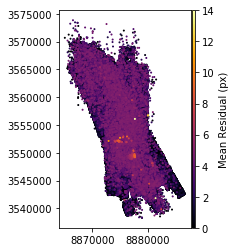

In [60]:
f,ax = plt.subplots()
clim = (0, 14)
img = reproj_fn_gdf.plot(ax=ax,markersize=1,column='mean_residual',cmap='inferno',vmin=clim[0],vmax=clim[1])
#adding cbar
sm = plt.cm.ScalarMappable(cmap='inferno',norm=plt.Normalize(vmin=clim[0], vmax=clim[1]))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
pltlib.add_cbar(ax,sm,label='Mean Residual (px)')

In [55]:
reproj_fn_gdf.sort_values(by='mean_residual',ascending=False).head(10000)

,lon,lat,height_above_datum,mean_residual,num_observations,geometry
760439,79.782733,30.297560,7252.964445,89.768257,3,POINT (8881373.192 3541855.982)
1043030,79.749362,30.407952,3491.094714,15.148455,2 # GCP,POINT (8877658.376 3556096.750)
1043032,79.770672,30.412885,4591.713786,12.323917,2 # GCP,POINT (8880030.620 3556733.557)
1043033,79.770697,30.412846,4580.082062,12.237862,2 # GCP,POINT (8880033.398 3556728.481)
1108042,79.725351,30.381651,2526.610592,11.079559,2 # GCP,POINT (8874985.506 3552702.515)
...,...,...,...,...,...,...
878371,79.720125,30.378129,5212.933830,3.452160,2,POINT (8874403.674 3552247.985)
229732,79.727845,30.453560,2285.213831,3.452136,2,POINT (8875263.146 3561984.942)
1358588,79.746059,30.355072,4883.787799,3.451827,2 # GCP,POINT (8877290.657 3549273.171)
695419,79.724753,30.384724,4856.275159,3.451711,3,POINT (8874918.922 3553098.960)


In [59]:
np.percentile(reproj_fn_gdf.mean_residual.values,(99))

2.962488805573878

In [62]:
#corner_coords
xmin,ymin,xmax,ymax = [376747.8,3360384.6,379732.1,3365001.9]

In [63]:
from shapely.geometry import box

In [67]:
geom = box(xmin,ymin,xmax,ymax)

In [69]:
print(geom)

POLYGON ((379732.1 3360384.6, 379732.1 3365001.9, 376747.8 3365001.9, 376747.8 3360384.6, 379732.1 3360384.6))


In [70]:
gdf_focus = gpd.GeoDataFrame(index=[0],geometry=[box(xmin,ymin,xmax,ymax)],crs={'init':'epsg:32644'})

In [75]:
gdf_focus.to_crs({'init':'epsg:4326'})

,geometry
0,"POLYGON ((79.74841 30.36941, 79.74788 30.41107..."


In [76]:
gdf_focus.to_crs({'init':'epsg:4326'}).to_file('/nobackupp11/sbhusha1/hma/chamoli/cartosat/local_coreg_bbox.geojson',driver='GeoJSON')